In [ ]:
# Import libraries
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import sys


# 1. Download YTD data for Ford (F)
ticker = "F"
data = yf.download(ticker, start=f"{pd.Timestamp.today().year}-01-01", group_by="ticker",auto_adjust=False)

# 2. Handle new multi-index format
if isinstance(data.columns, pd.MultiIndex):
    # Flatten columns
    data.columns = [col[1] for col in data.columns]
data = data.dropna(subset=["Close"])  # ensure clean

data

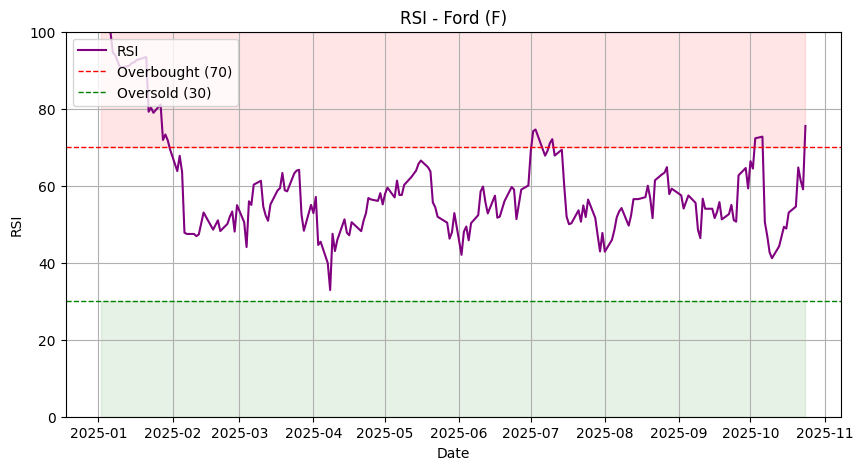

In [19]:
# 4. Plot RSI with Overbought/Oversold lines

# 3. Compute RSI, MACD, Bollinger Bands
data["RSI"] = ta.rsi(data["Close"], length=14)
macd = ta.macd(data["Close"])
data = pd.concat([data, macd], axis=1)
bbands = ta.bbands(data["Close"], length=20, std=2)
data = pd.concat([data, bbands], axis=1)



plt.figure(figsize=(10, 5))
plt.plot(data.index, data["RSI"], label="RSI", color="purple", linewidth=1.5)

# Add reference lines
plt.axhline(70, color="red", linestyle="--", linewidth=1, label="Overbought (70)")
plt.axhline(30, color="green", linestyle="--", linewidth=1, label="Oversold (30)")

# Optional: shaded regions
plt.fill_between(data.index, 70, 100, color="red", alpha=0.1)
plt.fill_between(data.index, 0, 30, color="green", alpha=0.1)

plt.title("RSI - Ford (F)")
plt.xlabel("Date")
plt.ylabel("RSI")
plt.legend(loc="upper left")
plt.grid(True)
plt.ylim(0, 100)
plt.show()



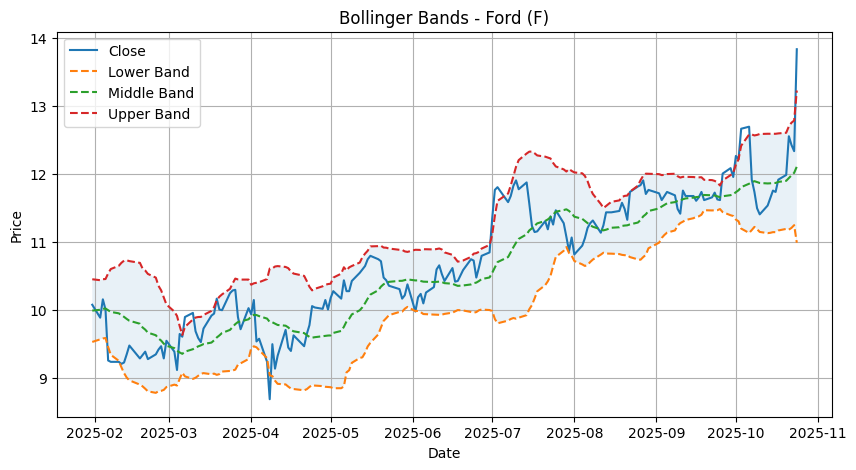

In [20]:


# --- Bollinger Bands: compute and plot robustly ---
bbands = ta.bbands(close=data["Close"].astype(float), length=20, std=2)

if bbands is None or bbands.empty:
    raise ValueError("Bollinger Bands could not be computed. Check input series and pandas_ta version.")

# (1) Select exactly one column for each band from bbands itself (not from `data`)
lower_s  = bbands.filter(like="BBL").iloc[:, 0]
middle_s = bbands.filter(like="BBM").iloc[:, 0]
upper_s  = bbands.filter(like="BBU").iloc[:, 0]

# (2) Ensure they're 1-D float arrays (no multi-dim dtypes sneaking in)
x        = bbands.index
lower    = np.asarray(lower_s, dtype="float64").ravel()
middle   = np.asarray(middle_s, dtype="float64").ravel()
upper    = np.asarray(upper_s, dtype="float64").ravel()
close    = np.asarray(data["Close"].reindex(x).astype(float), dtype="float64").ravel()  # align to bbands index

# (3) Optional: mask out NaNs (common at the start of the series)
mask = ~np.isnan(lower) & ~np.isnan(upper) & ~np.isnan(close)
x_m, lower_m, upper_m, middle_m, close_m = x[mask], lower[mask], upper[mask], middle[mask], close[mask]

# (4) Plot
plt.figure(figsize=(10, 5))
plt.plot(x_m, close_m, label="Close")
plt.plot(x_m, lower_m, label="Lower Band", linestyle="--")
plt.plot(x_m, middle_m, label="Middle Band", linestyle="--")
plt.plot(x_m, upper_m, label="Upper Band", linestyle="--")
plt.fill_between(x_m, lower_m, upper_m, alpha=0.1)
plt.title("Bollinger Bands - Ford (F)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [18]:
# 3. Create candlestick figure
fig = go.Figure(data=[
    go.Candlestick(
        x=data.index,
        open=data["Open"],
        high=data["High"],
        low=data["Low"],
        close=data["Close"],
        name="Ford (F)"
    )
])

# 4. Add titles and layout
fig.update_layout(
    title=f"Ford (F) Candlestick Chart – YTD {pd.Timestamp.today().year}",
    xaxis_title="Date",
    yaxis_title="Price ($)",
    xaxis_rangeslider_visible=True,
    template="ggplot2",  # or "plotly_white"
    width=900,
    height=500
)


# --- Auto-detect environment and set renderer ---
if "ipykernel" in sys.modules:              # Jupyter or VS Code interactive
    pio.renderers.default = "notebook_connected"
elif "spyder" in sys.modules:               # Spyder IDE
    pio.renderers.default = "browser"
else:                                       # Script or terminal run
    pio.renderers.default = "browser"

# --- Now display the chart ---
fig.show()


